# Regular Genomics Project **RNA Localisation**


---

**Problem definition**:

TODO


### **1.** Data Preparation

Firstly, we import several necessary packages and load in our data:

In [7]:
import pandas as pd
import numpy as np
from notes import read_model_file
from models import plot_line_graph, box_plot, pearson
from sklearn.model_selection import train_test_split
from keras.losses import KLDivergence
import datetime
from models import CNN
from keras.optimizers import Nadam

In [8]:
# Initializing test/train split


colab = False  #### Set colab flag ####

if colab:
    np.random.seed(3)
    url = 'https://www.dropbox.com/s/hv4uau8q4wwg00k/final_data.csv?dl=1'
    data_org = pd.read_csv(url)
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index)
else:
    np.random.seed(3)
    data_org = pd.read_csv('~/Downloads/final_data.csv')
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index) # TODO: note: we also have to preprocess the test set similary
    # TODO: colab

train_split, valid_split = train_test_split(train_data, random_state=42, test_size=0.2)

### **2** |  Initializations

We use as baseline model the [RNATracker](https://github.com/HarveyYan/RNATracker/blob/master/Models/cnn_bilstm_attention.py) model and a CNN model.


In [9]:
max_seq_len = train_data['seq'].apply(lambda x: len(x)).max()
# MODEL
model_path = "model_architectures/"

# Path where to save viz
model_architecture_path = "model_architecture_viz/deepRNA_adapt.png"

params_dict = read_model_file('model_architectures/deepRNA_adapt.yaml', max_seq_len)
param_dataLoader_valid = params_dict['param_dataLoader_valid']
param_dataLoader_train = params_dict['param_dataLoader_train']
params_model = params_dict['params_model']
params_train = params_dict['params_train']


In [10]:
import tensorflow_probability as tfp
def pearson(y_true, y_pred, sample_axis=0,
                event_axis=None,
                keepdims=False,
                eps=0.001):
    y_true /= (tfp.stats.stddev(y_true, sample_axis=sample_axis, keepdims=True)+eps)
    if y_pred is not None:
      y_pred /= (tfp.stats.stddev(y_pred, sample_axis=sample_axis, keepdims=True)+eps)

    return tfp.stats.covariance(
        x=y_true,
        y=y_pred,
        event_axis=event_axis,
        sample_axis=sample_axis,
        keepdims=keepdims)

model = CNN(input_size=(max_seq_len, 4),
            params_model=params_model,
            optimizer=Nadam(),
            loss=KLDivergence(),
            metrics=[pearson]
            )

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 34526, 4)]        0         
                                                                 
 conv1d_8 (Conv1D)           (None, 34520, 64)         1856      
                                                                 
 batch_normalization_10 (Ba  (None, 34520, 64)         256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 34520, 64)         0         
                                                                 
 conv1d_9 (Conv1D)           (None, 34514, 64)         28736     
                                                                 
 batch_normalization_11 (Ba  (None, 34514, 64)         256       
 tchNormalization)                                         

In [11]:
history = model.fit_and_evaluate(train_data=train_split, eval_data=valid_split,
                                 params_train_dataLoader=param_dataLoader_train,
                                 params_eval_dataLoader=param_dataLoader_valid,
                                 params_train=params_train)

Epoch 1/10
311/311 [==============================] - 3851s 12s/step - loss: 0.1895 - pearson: 0.1339 - val_loss: 0.2497 - val_pearson: 0.0628
Epoch 2/10
311/311 [==============================] - 3924s 13s/step - loss: 0.1713 - pearson: 0.1882 - val_loss: 12.0540 - val_pearson: 0.0059
Epoch 3/10
311/311 [==============================] - 4117s 13s/step - loss: 0.1693 - pearson: 0.2035 - val_loss: 11.1413 - val_pearson: 0.0017
Epoch 4/10
311/311 [==============================] - 4137s 13s/step - loss: 0.1685 - pearson: 0.2078 - val_loss: 9.3444 - val_pearson: -0.0340
Epoch 5/10
 63/311 [=====>........................] - ETA: 52:05 - loss: 0.1706 - pearson: 0.2094

KeyboardInterrupt: 

In [34]:
history.history['tf_pearson']

[0.10305633395910263,
 0.17237354815006256,
 0.19586281478405,
 0.210882306098938,
 0.21910853683948517,
 0.2260274440050125,
 0.23263335227966309,
 0.23749132454395294,
 0.2415289282798767,
 0.24513569474220276]

In [36]:
param_dataLoader_pred = {'batch_size': 32, 'shuffle': False, 'padding_length': max_seq_len}
pred = model.predict(valid_split, param_dataLoader_pred)

78/78 [==============================] - 2s 31ms/step


In [7]:
import tensorflow as tf
import keras as k
def tf_pearson(y_true, y_pred, sample_axis=0,
                event_axis=None,
                keepdims=False,
                name=None,
                eps=0.001):
    y_true /= (tfp.stats.stddev(y_true, sample_axis=sample_axis, keepdims=True)+eps)
    if y_pred is not None:
      y_pred /= (tfp.stats.stddev(y_pred, sample_axis=sample_axis, keepdims=True)+eps)

    return tfp.stats.covariance(
        x=y_true,
        y=y_pred,
        event_axis=event_axis,
        sample_axis=sample_axis,
        keepdims=keepdims)

def output_normalization(data: pd.DataFrame) -> pd.DataFrame:
    sum_vec = data.sum(axis=1)
    return data.divide(sum_vec, axis='index')

data = tf.constant(output_normalization(valid_split.iloc[:, 0:9]), dtype=float)
inp = k.Input(data)
inp1 = k.layers.Dense(inp, activation='relu')

TypeError: only integer scalar arrays can be converted to a scalar index

In [16]:
model.print_model(model_architecture_path)
import datetime
import pydot
time_date = datetime.datetime.now().date()
# time_hour = datetime.datetime.now().time()

model_output = f"model_outputs/simple_cnn_{time_date}.h5"

model.save_model(model_output)

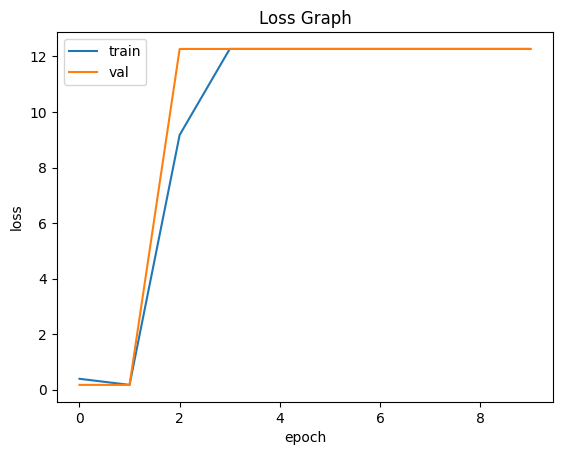

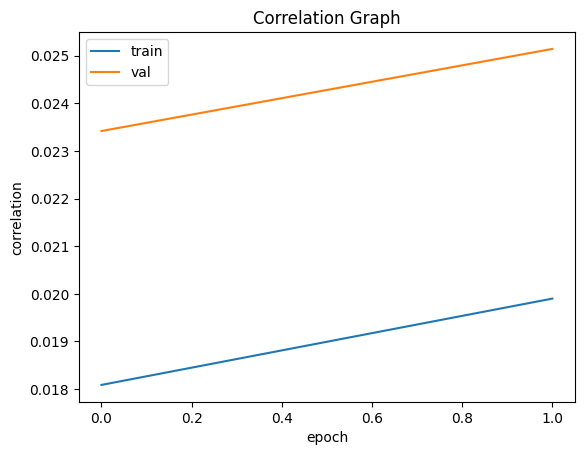

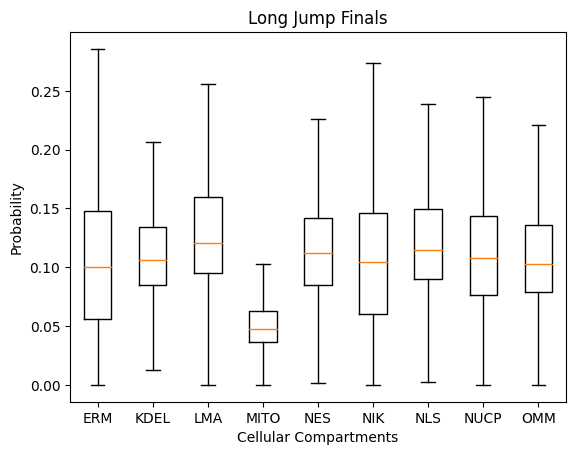

In [ ]:
plt_data = [history.history['loss'], history.history['val_loss']]
plot_line_graph(plt_data, "Loss Graph", 'loss', 'epoch', ['train', 'val'])

plt_data = [history.history['tf_pearson'], history.history['val_tf_pearson']]
plot_line_graph(plt_data, "Correlation Graph", 'correlation', 'epoch', ['train', 'val'])

box_plot(train_data)

In [ ]:
test_result = model.evaluate(test_data, **param_dataLoader_valid)
result = dict(zip(model.model.metrics_names, test_result))
TEST_ACCURACY = result['accuracy']
TEST_LOSS = result['loss']

In [ ]:
VALIDATION_ACCURACY

In [ ]:
VALIDATION_LOSS